# Should one consider pairs with sligthly mismatching coordinates as duplicates?
Is there a significant enrichment of pairs shifted on one or both sides by just a few base pairs? If so, we should allow small offsets in the deduplication procedure.

Let's investigate it in an example dataset. It was generated using the Arima Hi-C kit, and published in Ghurye et al. 2019.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pairtools.lib import headerops, fileio
from pairtools.lib.pairsio import read_pairs

from scipy.spatial import KDTree # Change to cKDTree for faster performance with scipy <1.6.0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

In [3]:
def dup_dist(df, r, cols=['pos1', 'pos2'], p=1):
    # KDtree is a data structure that allows for fast nearest-neighbor lookup
    tree = KDTree(df[cols].to_numpy())
    # Find all pairs within a distance r of each other
    pairs = tree.query_pairs(r, p=p, output_type='ndarray')
    df['dist1'] = pd.NA
    df['dist2'] = pd.NA
    ids1 = df['readID'].to_numpy()[pairs[:, 0]]
    ids2 = df['readID'].to_numpy()[pairs[:, 1]]
    # Calculate the distance between the pairs (we know they are within r of each other, but not the exact distance)
    dists1 = np.abs(df[cols[0]].to_numpy()[pairs[:, 1]]-df[cols[0]].to_numpy()[pairs[:, 0]].astype(int))
    dists2 = np.abs(df[cols[1]].to_numpy()[pairs[:, 1]]-df[cols[1]].to_numpy()[pairs[:, 0]].astype(int))
    return pd.DataFrame({'id1':ids1, 'id2':ids2, 'dist1':dists1, 'dist2':dists2}).sort_values(by=['id1', 'id2']).reset_index(drop=True)

def calculate_dup_dists(df, cols=['pos1', 'pos2'], r=20):
    df = df.drop(columns='readID').reset_index().rename(columns={'index': 'readID'}) # Add fake read IDs, according to the order of the pairs
    dup_dists = df.groupby(['chrom1', 'chrom2', 'strand1', 'strand2']).apply(dup_dist, r=r, p=np.inf, # p specifies the Minkowski distance parameter, inf means the maximum distance on either side is r
                                                                             cols=cols, include_groups=False).sort_values(by=['id1', 'id2']).reset_index(drop=True)
    return dup_dists

This is a file created by merging the nodups and dups output from the distiller pipeline using pairtools merge. This way it contains all the original duplicates, but not unmapped reads.

In [4]:
!wget https://osf.io/49qmg/download -O SRR6675327.hg19.sampled.pairs.gz 

--2025-06-19 08:37:43--  https://osf.io/49qmg/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.de-1.osf.io/v1/resources/638ue/providers/osfstorage/685400f571ee75a245c89bed?action=download&direct&version=1 [following]
--2025-06-19 08:37:43--  https://files.de-1.osf.io/v1/resources/638ue/providers/osfstorage/685400f571ee75a245c89bed?action=download&direct&version=1
Resolving files.de-1.osf.io (files.de-1.osf.io)... 35.186.249.111
Connecting to files.de-1.osf.io (files.de-1.osf.io)|35.186.249.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223185734 (213M) [application/octet-stream]
Saving to: ‘SRR6675327.hg19.sampled.pairs.gz’

SRR6675327.hg19.sam 100%[===================>] 212.85M  24.9MB/s    in 9.0s    

2025-06-19 08:37:53 (23.6 MB/s) - ‘SRR6675327.hg19.sampled.pairs.gz’ saved [223185734/223185734]



In [5]:
pairs_df, header, chromsizes = read_pairs('SRR6675327.hg19.sampled.pairs.gz')

In [6]:
# Remove unnecessary chromosomes and sample 1 mln pairs for faster computation
pairs_df = pairs_df[pairs_df['chrom1'].isin([f'chr{x}' for x in list(range(1, 23))+['X', 'Y']]) & \
                    pairs_df['chrom2'].isin([f'chr{x}' for x in list(range(1, 23))+['X', 'Y']])]

Now we find pairs that are within 50 bp of each other on both sides, and calculate distances between them.

In [7]:
dup_dists = calculate_dup_dists(pairs_df,
                                 cols=['pos51', 'pos52'], # Use 5-prime positions of alignment (in this case, stored in the pairs file)
                                 r=50, # Consider pairs with distance less than 50 bp
                                 )

In [8]:
# id1/2 correspond to the fake readIDs we created earlier 
dup_dists.head()

,id1,id2,dist1,dist2
0,372,373,4,10
1,553,554,0,0
2,642,643,0,0
3,717,718,0,0
4,1125,1126,0,0


In [9]:
# Convert the distances to a matrix of counts
counts = dup_dists[['dist1', 'dist2']].value_counts().sort_index()
counts_2d = counts.reset_index().pivot(index='dist1', columns='dist2', values='count')

In [10]:
# Rows correspond to the distance between the left ends of the pairs, columns to the distance between the right ends
counts_2d.head()

dist2,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
dist1,,,,,,,,,,,,,,,,,,,,,
0,53000,7681,8992,5409,5440,5144,5532,5167,5307,5389,...,3727,3728,3038,3117,3496,2773,3045,3050,2835,3137
1,18218,3926,3582,2474,2392,2463,2699,2145,2370,2393,...,1608,1574,1285,1230,1354,1339,1267,1029,1134,1398
2,12700,2835,1715,1626,1740,1670,1938,1643,1486,1600,...,1487,1473,1094,1008,1309,1064,1150,989,1002,1203
3,13393,2862,1838,1556,1729,1686,1726,1649,1536,1551,...,1386,1378,994,1022,1237,1088,1142,1059,1023,1217
4,13460,3040,2063,2060,2139,1878,2056,1891,1832,1903,...,1600,1582,1287,1277,1428,1282,1322,1179,1174,1326


Now we plot the data as a heatmap. We use log scale since the range of values is huge.

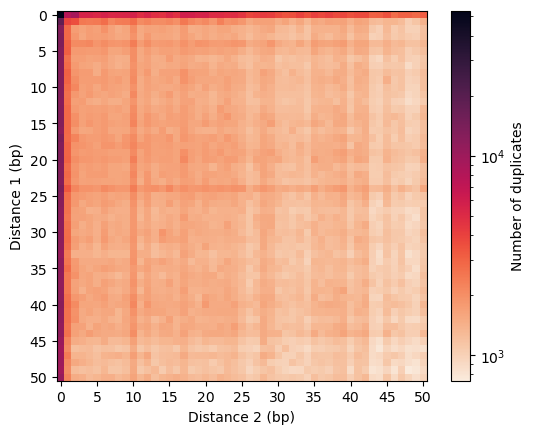

In [11]:
# Now we plot
f, ax = plt.subplots()
im = ax.imshow(counts_2d,
               norm=LogNorm(),
               cmap='rocket_r',
               )
cb = plt.colorbar(im, ax=ax)
ax.set(xticks=np.arange(0, 51, 5), yticks=np.arange(0, 51, 5), ylabel='Distance 1 (bp)', xlabel='Distance 2 (bp)')
cb.set_label('Number of duplicates')

Interestingly, there is a strong enrichment of the first columns / top row, which almost doesn't get weaker with increasing distance.

Probably it corresponds to pairs where one end of the final sequenced fragment is at an unligated restriction site used in the procedure. When this analysis is performed with micro-C data, where the enzyme doesn't cut at specific sequences, this is not observed.

Let's zoom into the top-left corner. That's where one might observe enrichment of nor precisely matching duplicates.

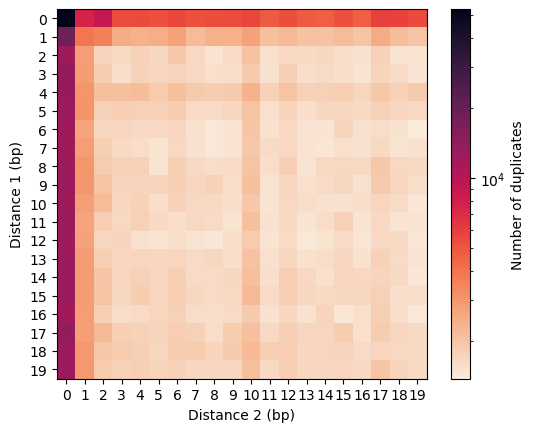

In [12]:
f, ax = plt.subplots()
im = ax.imshow(counts_2d.iloc[:20, :20],
               norm=LogNorm(),
               cmap='rocket_r',
               )
cb = plt.colorbar(im, ax=ax)
ax.set(xticks=np.arange(20), yticks=np.arange(20), ylabel='Distance 1 (bp)', xlabel='Distance 2 (bp)')
cb.set_label('Number of duplicates')

In [13]:
normed = counts_2d / np.sqrt(counts_2d.mean(axis=0).to_numpy() * counts_2d.mean(axis=1).to_numpy()[:, np.newaxis])

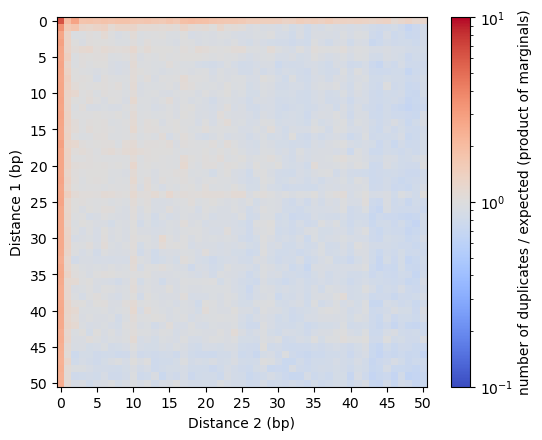

In [14]:
f, ax = plt.subplots()
im = ax.imshow(normed,
               norm=LogNorm(vmin=0.1, vmax=10),
               cmap='coolwarm',
               )
cb = plt.colorbar(im, ax=ax)
ax.set(xticks=np.arange(0, 51, 5), yticks=np.arange(0, 51, 5), ylabel='Distance 1 (bp)', xlabel='Distance 2 (bp)')
cb.set_label('number of duplicates / expected (product of marginals)')

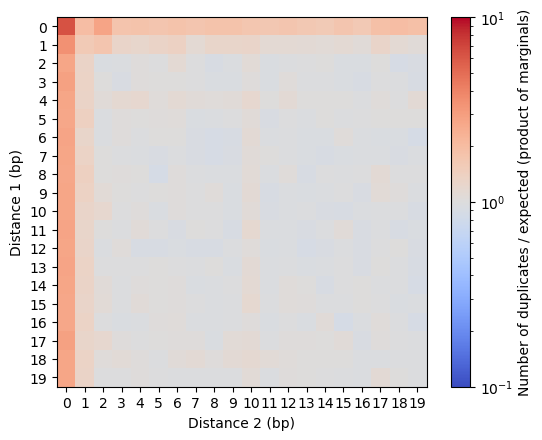

In [15]:
f, ax = plt.subplots()
im = ax.imshow(normed.iloc[:20, :20],
               norm=LogNorm(vmin=0.1, vmax=10),
               cmap='coolwarm',
               )
cb = plt.colorbar(im, ax=ax)
ax.set(xticks=np.arange(20), yticks=np.arange(20), ylabel='Distance 1 (bp)', xlabel='Distance 2 (bp)')
cb.set_label('Number of duplicates / expected (product of marginals)')